In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

def hidden_values(layer):
    wts = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(wts)
    return (-lim, lim)

class Actor(nn.Module):

    def __init__(self, state_size, action_size, seed=0, fc1_dims=256, fc2_dims=128):

        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_dims)
        self.fc2 = nn.Linear(fc1_dims, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, action_size)
        self.bn1 = nn.BatchNorm1d(fc1_dims)
        self.bn2 = nn.BatchNorm1d(fc2_dims)
        self.reset_parameters()

    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_values(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_values(self.fc2))
        self.fc3.weight.data.uniform_(-0.003, 0.003)

    def forward(self, state):

        if state.dim() == 1:
            state = torch.unsqueeze(state,0)
        x = F.relu(self.fc1(state))
        x = self.bn1(x)
        x = F.relu(self.fc2(x))
        return torch.tanh(self.fc3(x))

class Critic(nn.Module):

    def __init__(self, full_state_size, actions_size, seed=0, fcs1_units=256, fc2_dims=128):
       
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(full_state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units+actions_size, fc2_dims)
        self.fc3 = nn.Linear(fc2_dims, 1)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_dims)
        self.reset_parameters()

    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_values(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_values(self.fc2))
        self.fc3.weight.data.uniform_(-0.003, 0.003)

    def forward(self, state, action):
        xs = F.relu(self.fcs1(state))
        xs = self.bn1(xs)
        x = torch.cat((xs, action), dim=1)
        x = F.relu(self.fc2(x))
        return self.fc3(x)


In [2]:
import numpy as np
import random
import copy
from collections import namedtuple, deque

#from nn_model import Actor, Critic

import torch
import torch.nn.functional as F
import torch.optim as optim

replaymem_size = 1000   # replay buffer size
batch_size = 128        # batch size
tau = 0.001              # for soft update of target parameters
alpha = 0.001         # learning rate of the actor
beta = 0.003        # learning rate of the critic
weight_decay = 0        # 2nd layer weight decay

noise_reductionrate = 0.99
eps_beforetraining = 100
initial_noise = 1.0
final_noise = 0.1

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class Agent():

    def __init__(self, state_size, action_size, num_agents, seed_value):

        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(seed_value)

        self.actor_current = Actor(state_size, action_size, seed_value).to(device)
        self.actor_target = Actor(state_size, action_size, seed_value).to(device)
        self.actor_optimizer = optim.Adam(self.actor_current.parameters(), lr=alpha)

        self.critic_current = Critic(state_size*num_agents, action_size*num_agents, seed_value).to(device)
        self.critic_target = Critic(state_size*num_agents, action_size*num_agents, seed_value).to(device)
        self.critic_optimizer = optim.Adam(self.critic_current.parameters(), lr=beta, weight_decay=weight_decay)

        self.soft_update(self.critic_current, self.critic_target, 1)
        self.soft_update(self.actor_current, self.actor_target, 1)

        self.noise = OUNoise(action_size, seed_value)
        self.noise_reduction_ratio = initial_noise

    def act(self, state, eps_num, add_noise=True):

        state = torch.from_numpy(state).float().to(device)
        self.actor_current.eval()
        with torch.no_grad():
            action = self.actor_current(state).cpu().data.numpy()
        self.actor_current.train()

        if add_noise:
            if eps_num > eps_beforetraining and self.noise_reduction_ratio > final_noise :
                self.noise_reduction_ratio = noise_reductionrate**(eps_num-eps_beforetraining)
            action += self.noise_reduction_ratio * self.add_noise2()
        return np.clip(action, -1, 1)

    def add_noise2(self):
        noise = 0.5*np.random.standard_normal(self.action_size)
        return noise

    def reset(self):
        self.noise.reset()

    def learn(self, experiences, gamma):

        full_states, actions, actor_current_actions, actor_target_actions, agent_state, agent_action, agent_reward, agent_done, next_states, next_full_states = experiences

        #update critic
        Q_targets_next = self.critic_target(next_full_states, actor_target_actions)
        Q_targets = agent_reward + (gamma * Q_targets_next * (1 - agent_done))
        Q_expected = self.critic_current(full_states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        self.critic_optimizer.step()

        #update actor
        actor_loss = -self.critic_current(full_states, actor_current_actions).mean()
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

    def hard_copy_weights(self, target, source):

        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

    def soft_update(self, current_model, target_model, tau):

        for target_param, local_param in zip(target_model.parameters(), current_model.parameters()):
            target_param.data.copy_(tau*local_param.data + (1.0-tau)*target_param.data)

class OUNoise:

    def __init__(self, size, seed, mu=0., theta=0.15, sigma=0.1):
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.reset()
        self.size = size

    def reset(self):
        self.state = copy.copy(self.mu)

    def sample(self):
        x = self.state
        dx = self.theta * (self.mu - x) + self.sigma * np.random.standard_normal(self.size)
        self.state = x +dx
        return self.state


In [3]:
import torch
import random
from collections import namedtuple, deque
import numpy as np

#from ddpg import Agent

replaymem_size = 10000  # replay buffer size
batch_size = 128        # batch size
gamma = 0.99            # discount factor
tau = 0.001             # for soft update of target parameters

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

class MADDPG():
    
    def __init__(self, state_size, action_size, num_agents, seed_value):
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed_value = random.seed(seed_value)

        self.agents = [Agent(state_size, action_size, num_agents, seed_value) for i in range(num_agents)]
        self.batch_memory = replay_buffer(replaymem_size, batch_size, seed_value)
 
    def reset_noise(self):
        for agent in self.agents:
            agent.reset()

    def act(self, state, eps_num , add_noise=True):
        actions = []
        for agent_state, agent in zip(state, self.agents):
            action = agent.act(agent_state, eps_num , add_noise)
            action = np.reshape(action, newshape=(-1))
            actions.append(action)
        actions = np.stack(actions)
        return actions

    def step(self, eps_num , state, action, reward, next_state, done):
        full_state = np.reshape(state, newshape=(-1)) #Joining all states into 1D array
        next_full_state = np.reshape(next_state, newshape=(-1)) #Joining all states into 1D array
        
        self.batch_memory.add(state, full_state, action, reward, next_state, next_full_state, done)
        
        if len(self.batch_memory) > batch_size and eps_num  > 100:
            for l_cnt in range(3):
                for agent in self.agents:
                    experiences = self.batch_memory.sample_experiences()
                    self.learn(experiences, agent, gamma)

                for agent in self.agents:
                    agent.soft_update(agent.actor_current, agent.actor_target, tau)
                    agent.soft_update(agent.critic_current, agent.critic_target, tau)
  
    def learn(self, experiences, agent, gamma):
        states, full_states, actions, rewards, next_states, next_full_states, dones = experiences
        actor_target_actions = torch.zeros(actions.shape, dtype=torch.float, device=device)
        for agent_num, agent_i in enumerate(self.agents):
            if agent == agent_i:
                agent_id = agent_num
            agent_i_current_state = states[:,agent_num]
            actor_target_actions[:,agent_num] = agent_i.actor_target.forward(agent_i_current_state)
        actor_target_actions = actor_target_actions.view(batch_size, -1)
        agent_state = states[:,agent_id]
        agent_action = actions[:,agent_id]
        agent_reward = rewards[:,agent_id].view(-1,1)
        agent_done = dones[:,agent_id].view(-1,1)
        
        actor_local_actions = actions.clone()
        actor_local_actions[:, agent_id] = agent.actor_current.forward(agent_state)
        actor_local_actions = actor_local_actions.view(batch_size, -1)
        actions = actions.view(batch_size, -1)
        
        agent_experience = (full_states, actions, actor_local_actions, actor_target_actions,
                            agent_state, agent_action, agent_reward, agent_done,
                            next_states, next_full_states)

        agent.learn(agent_experience, gamma)

    def save(self):
        for idx, agent in enumerate(self.agents):
            chk_actor_filename = '/content/sample_data/checkpoint_agent{}_actor.pth'.format(idx)
            chk_critic_filename = '/content/sample_data/checkpoint_critic{}_critic.pth'.format(idx)
            torch.save(agent.actor_current.state_dict(), chk_actor_filename)
            torch.save(agent.critic_current.state_dict(), chk_critic_filename)

class replay_buffer(object):

    def __init__(self, replaymem_size, batch_size, seed):

        self.batch_memory = deque(maxlen=replaymem_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", field_names=['state', 'full_state', 'action', 'reward', 'next_state', 'next_full_state','done'])
        self.seed = random.seed(seed)
    
    def add(self, state, full_state, action, reward, next_state, next_full_state, done):
        e = self.experience(state, full_state, action, reward, next_state, next_full_state, done)
        self.batch_memory.append(e)
    
    def sample_experiences(self):
        experiences = random.sample(self.batch_memory, k=self.batch_size)
        
        states = torch.from_numpy(np.array([e.state for e in experiences if e is not None])).float().to(device)
        full_states = torch.from_numpy(np.array([e.full_state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.array([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.array([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.array([e.next_state for e in experiences if e is not None])).float().to(device)
        next_full_states = torch.from_numpy(np.array([e.next_full_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.array([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)

        return (states, full_states, actions, rewards, next_states, next_full_states, dones)

    def __len__(self):
        return len(self.batch_memory)    

In [4]:

import numpy as np

action_new = 0

def priority_action(state):
    if state[2] == 3:
        return 2
    else:
        return np.argmax(state)

def goal_state(cur_state):
    if(np.sum(cur_state)==3):
        done = True
        return done

def checkBoundaries(good, cur_state):
    cur_state = np.int_(cur_state)
    for i in range(np.size(cur_state)):
        if (cur_state[i]>3 or cur_state[i]<1):
            done = True
            reward = -2
            return reward, done

    done = False
    if good == 1:
        reward = 1
    else:
        reward = -1

    return reward, done

def actionClassifier(action_val):
    global action_new
    if action_val >=-1.0 and action_val < -0.334:
        action_new = 0
    elif action_val >=-0.334 and action_val < 0.332:
        action_new = 1
    elif action_val >=0.332 and action_val <= 1.0:
        action_new = 2

    return action_new


def nextState(good, cur_state):

    if good == 1:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]-1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done

    elif good == 0:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]+1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done

class Hospital_Agent():
  
    def step(self, action, cur_state):

        action = actionClassifier(action)

        done = False
        cur_state = np.array(cur_state)
        done = goal_state(cur_state)
        if done == True:
            reward = 10
            return cur_state, reward, done, {}

        else:
            self.priority = priority_action(cur_state)

            if(action == self.priority):
                self.good = 1
                nextstate, reward, done = nextState(self.good, cur_state)

            elif(action != self.priority):
                self.good = 0
                nextstate, reward, done = nextState(self.good, cur_state)

        return (nextstate), reward, done, {}

    def reset(self):
        self.elec_random = np.random.choice(np.array([1,2,3]))
        self.trans_random = np.random.choice(np.array([1,2,3]))
        self.trend_random = np.random.choice(np.array([1,2,3]))
        self.state = np.array([self.elec_random, self.trans_random, self.trend_random])
        return self.state


In [5]:
 
import numpy as np
from gym import spaces

action_new = 0

def priority_action(state):
    if state[0] == 3:
        return 0
    else:
        return np.argmax(state)

def goal_state(cur_state):
    if(np.sum(cur_state)==3):
        done = True
        return done

def checkBoundaries(good, cur_state):
    cur_state = np.int_(cur_state)
    for i in range(np.size(cur_state)):
        if (cur_state[i]>3 or cur_state[i]<1):
            done = True
            reward = -2
            return reward, done

    done = False
    if good == 1:
        reward = 1
    else:
        reward = -1

    return reward, done

def actionClassifier(action_val):
    global action_new
    if action_val >=-1.0 and action_val < -0.334:
        action_new = 0
    elif action_val >=-0.334 and action_val < 0.332:
        action_new = 1
    elif action_val >=0.332 and action_val <= 1.0:
        action_new = 2

    return action_new


def nextState(good, cur_state):  

    if good == 1:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]-1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done

    elif good == 0:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]+1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done
      
class Powerstation_Agent():

    def __init__(self):

        self.action_space = spaces.Box(
            low= -1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32 )
        
    def step(self, action, cur_state):

        action = actionClassifier(action)
    
        done = False
        cur_state = np.array(cur_state)
        done = goal_state(cur_state)
        if done == True:
            reward = 10
            return cur_state, reward, done, {}

        else:
            self.priority = priority_action(cur_state)

            if(action == self.priority):
                self.good = 1
                nextstate, reward, done = nextState(self.good, cur_state)

            elif(action != self.priority):
                self.good = 0
                nextstate, reward, done = nextState(self.good, cur_state)

        return (nextstate), reward, done, {}
    
    def reset(self):
        self.elec_random = np.random.choice(np.array([1,2,3]))
        self.trans_random = np.random.choice(np.array([1,2,3]))
        self.trend_random = np.random.choice(np.array([1,2,3]))
        self.state = np.array([self.elec_random, self.trans_random, self.trend_random])
        return self.state


In [6]:
 
import numpy as np
from gym import spaces

action_new = 0

def priority_action(state):
    if state[1] == 3:
        return 1
    else:
        return np.argmax(state)
    # temp = []
    # max = np.argmax(state)
    # for i in range(np.size(state)):
    #     if(state[i]==state[max]):
    #         temp.append(i)
    # return np.random.choice(temp)

def goal_state(cur_state):
    if(np.sum(cur_state)==3):
        done = True
        return done

def checkBoundaries(good, cur_state):
    cur_state = np.int_(cur_state)
    for i in range(np.size(cur_state)):
        if (cur_state[i]>3 or cur_state[i]<1):
            done = True
            reward = -2
            return reward, done

    done = False
    if good == 1:
        reward = 1
    else:
        reward = -1

    return reward, done

def actionClassifier(action_val):
    global action_new
    if action_val >=-1.0 and action_val < -0.334:
        action_new = 0
    elif action_val >=-0.334 and action_val < 0.332:
        action_new = 1
    elif action_val >=0.332 and action_val <= 1.0:
        action_new = 2

    return action_new


def nextState(good, cur_state):  

    if good == 1:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]-1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done

    elif good == 0:
        index = np.argmax(cur_state)
        cur_state[index] = cur_state[index]+1
        reward, done = checkBoundaries(good, cur_state)
        next_state = np.copy(cur_state)
        return next_state, reward, done
      
class Transport_Agent():

    def __init__(self):
    
        self.action_space = spaces.Box(
            low= -1.0,
            high=1.0,
            shape=(1,),
            dtype=np.float32 )
        
    def step(self, action, cur_state):

        action = actionClassifier(action)
    
        done = False
        cur_state = np.array(cur_state)
        done = goal_state(cur_state)
        if done == True:
            reward = 10
            return cur_state, reward, done, {}

        else:
            self.priority = priority_action(cur_state)

            if(action == self.priority):
                self.good = 1
                nextstate, reward, done = nextState(self.good, cur_state)

            elif(action != self.priority):
                self.good = 0
                nextstate, reward, done = nextState(self.good, cur_state)

        return (nextstate), reward, done, {}
    
    def reset(self):
        self.elec_random = np.random.choice(np.array([1,2,3]))
        self.trans_random = np.random.choice(np.array([1,2,3]))
        self.trend_random = np.random.choice(np.array([1,2,3]))
        self.state = np.array([self.elec_random, self.trans_random, self.trend_random])
        return self.state


In [7]:
import numpy as np

hospital = Hospital_Agent()
power = Powerstation_Agent()
trans = Transport_Agent()

h_returns = []
next_states = []
rewards = []
dones = []
info = []

class env():

    def __init__(self, num_agents=3, state_space=3, action_space=1):

        self.num_agents = num_agents
        self.state_space = state_space
        self.action_space = action_space
       
    def reset_all():
    
        h_env = np.array(hospital.reset())
        p_env = np.array(power.reset())
        w_env = np.array(trans.reset())
        
        return np.array([p_env, w_env, h_env])
    
    def step(action, cur_state):

        h_returns = []
     
        h_returns.append(power.step(action[0], cur_state[0]))
        h_returns.append(trans.step(action[1], cur_state[1]))
        h_returns.append(hospital.step(action[2], cur_state[2]))
        
        h_returns_f = np.array(h_returns)

        next_states = []
        rewards = []
        dones = []
        info = []

        for i in range(3):

            next_states.append(h_returns_f[i, 0])
            rewards.append(h_returns_f[i, 1])
            dones.append(h_returns_f[i, 2])
            info.append(h_returns_f[i, 3])

        return (next_states), (rewards), (dones), (info)
        # [0]=next state, [1] = reward, [2] = done, [3] = {}


In [8]:
import matplotlib.pyplot as plt 
import numpy as np

def plotLearning(scores, filename, x=None, window=5):   
    N = len(scores)
    running_avg = np.empty(N)
    for t in range(N):
	    running_avg[t] = np.mean(scores[max(0, t-window):(t+1)])
    if x is None:
        x = [i for i in range(N)]
    plt.ylabel('Reward')       
    plt.xlabel('Episode')                     
    plt.plot(x, running_avg)
    plt.savefig(filename)

In [9]:
import torch
#from maddpg import MADDPG
from collections import deque
#from Agents.full_env import env
import time, os
import numpy as np
#from graph import plotLearning

In [10]:
#statesize, actionsize, no of agents, random seed
num_agents = 3
action_size = 1
state_size = 3
seed = 20
maddpg = MADDPG(num_agents, action_size, state_size, seed)

In [11]:
scores_max_hist = []
scores_mean_hist = []
n_episodes = 750

In [12]:
def maddpg_train(n_episodes):
    
    scores_deque = deque(maxlen=100)
    solved = False
    
    for i_episode in range(n_episodes):
        cur_states = env.reset_all()
        #print(cur_states)
        scores = np.zeros(num_agents)
        maddpg.reset_noise()
        step = 0
        while True:
            
            step+=1
            actions = maddpg.act(cur_states, i_episode)
            #print(actions)
            next_states,  rewards, dones, info = env.step(actions,cur_states)
            #print(next_states,  rewards, dones, info)

            scores += rewards
            
            maddpg.step(i_episode, cur_states, actions, rewards, next_states, dones)
            
            if np.any(dones):
                break
                
            cur_states = next_states
            
        score_max = np.max(scores)
        scores_deque.append(score_max)
        score_mean = np.mean(scores_deque)
        
        scores_max_hist.append(score_max)
        scores_mean_hist.append(score_mean)
        
        print('\n{} episode\tavg score {:.5f}\tmax score {:.5f}'.format(i_episode, np.mean(scores_deque), score_max), end='')
        if solved == False and score_mean >= 11:
            print('\nEnvironment solved after {} episodes with the average score {}\n'.format(i_episode, score_mean))
            maddpg.save()
            solved = True
            break

    filename = 'maddpg.png'
    plotLearning(scores_mean_hist, filename, window=100)
  

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



0 episode	avg score 2.00000	max score 2.00000
1 episode	avg score 1.50000	max score 1.00000
2 episode	avg score 1.33333	max score 1.00000
3 episode	avg score 1.25000	max score 1.00000
4 episode	avg score 1.40000	max score 2.00000
5 episode	avg score 1.33333	max score 1.00000
6 episode	avg score 1.28571	max score 1.00000
7 episode	avg score 1.25000	max score 1.00000
8 episode	avg score 2.33333	max score 11.00000
9 episode	avg score 2.20000	max score 1.00000
10 episode	avg score 2.09091	max score 1.00000
11 episode	avg score 2.00000	max score 1.00000
12 episode	avg score 2.61538	max score 10.00000
13 episode	avg score 2.28571	max score -2.00000
14 episode	avg score 2.06667	max score -1.00000
15 episode	avg score 2.00000	max score 1.00000
16 episode	avg score 1.94118	max score 1.00000
17 episode	avg score 1.88889	max score 1.00000
18 episode	avg score 1.68421	max score -2.00000
19 episode	avg score 1.50000	max score -2.00000
20 episode	avg score 1.38095	max score -1.00000
21 episode	avg 

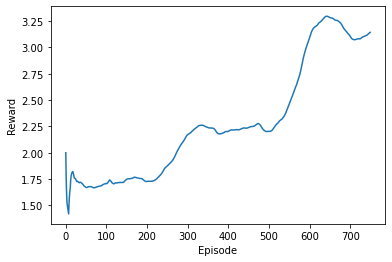

In [13]:
maddpg_train(n_episodes)

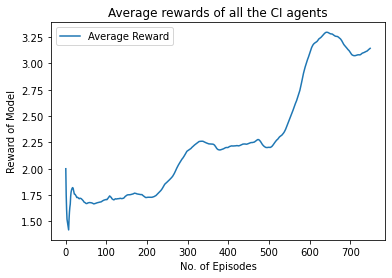

In [17]:
window=100
N = len(scores_mean_hist)
running_avg = np.empty(N)
for t in range(N):
  running_avg[t] = np.mean(scores_mean_hist[max(0, t-window):(t+1)])
x = [i for i in range(N)]

plt.plot(x, running_avg,label="Average Reward")
plt.plot()
plt.ylabel('Reward of Model')       
plt.xlabel('No. of Episodes')    
plt.title("Average rewards of all the CI agents")
plt.legend()
plt.show()
